In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, EarlyStoppingCallback, MBartConfig
from transformers import MBartForConditionalGeneration, MBartTokenizerFast,MBartTokenizer,Trainer, TrainingArguments

from transformers import DataCollatorForSeq2Seq
from hftrim.TokenizerTrimmer import TokenizerTrimmer
from hftrim.ModelTrimmers import MBartTrimmer

from transformers import PreTrainedTokenizerFast
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset
from datasets import concatenate_datasets
from random import randrange
import evaluate
import nltk
import numpy as np
from collections import Counter
from ast import literal_eval
from nltk.tokenize import sent_tokenize
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/risto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
# !pip install peft

In [4]:
# !pip install nltk

In [5]:
# !pip install evaluate

In [6]:
# !pip install rouge_score

In [7]:
# !pip install py7zr

In [8]:
# !pip install transformers --upgrade

## model

In [4]:
model_id="facebook/mbart-large-cc25"
src_lang = "et_EE" # Example source language code
tgt_lang = "et_EE" # Example target language code

In [10]:
tokenizer = MBartTokenizerFast.from_pretrained(model_id)
tokenizer_slow = MBartTokenizer.from_pretrained(model_id)
model = MBartForConditionalGeneration.from_pretrained(model_id)

In [11]:
# Important: Set both source and target languages
tokenizer.src_lang = src_lang
tokenizer.tgt_lang = tgt_lang

tokenizer_slow.src_lang = src_lang
tokenizer_slow.tgt_lang = tgt_lang

In [12]:
def msize(m):
    return sum(p.numel() for p in m.parameters())
#share of parambs in embedding
print(msize(model.model.shared) / msize(model))   
print(msize(model.lm_head) / msize(model))  

0.41913215486098887
0.41913215486098887


## data

In [5]:
dataset_id = "TalTechNLP/LongSumEt"
dataset = load_dataset(dataset_id)

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Train dataset size: 8656
Test dataset size: 481


In [6]:
dataset['train']=dataset['train'].filter(lambda example, idx: example['bulletpoints'] is not None and example['text'] is not None, with_indices=True)
dataset['test'] = dataset['test'].filter(lambda example, idx: example['bulletpoints'] is not None and example['text'] is not None, with_indices=True)

In [7]:
print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Train dataset size: 8656
Test dataset size: 481


In [8]:
train_dataset = dataset['train'].filter(lambda example, idx: example['bulletpoints'] is not None and example['text'] is not None, with_indices=True)
train_dataset

Dataset({
    features: ['text', 'long_summary', 'short_summary', 'bulletpoints', 'timestamp', 'url', 'source'],
    num_rows: 8656
})

In [9]:
test_dataset = dataset['test'].filter(lambda example, idx: example['bulletpoints'] is not None and example['text'] is not None, with_indices=True)
test_dataset

Dataset({
    features: ['text', 'long_summary', 'short_summary', 'bulletpoints', 'timestamp', 'url', 'source'],
    num_rows: 481
})

In [10]:
print(' ## '.join(literal_eval(train_dataset[0]['bulletpoints'])))

Marje Oona kritiseerib poliitikute vaktsineerimisvastast tegevust ## Valeinfo kummutamine Indias kasutatavate ravimite efektiivsuse kohta ## Rõhutab vaktsiinide olulisust COVID-19 vastu võitlemisel ## Indias pandeemia laastav mõju ja vaktsineerimise tähtsus ## Üleskutse poliitikutele aidata kriisi lahendada


In [11]:
def format_bulletpoints(example):
    example["bulletpoints"] = ' ## '.join(literal_eval(example["bulletpoints"]))
    return example

In [12]:
train_dataset = train_dataset.map(format_bulletpoints)
test_dataset = test_dataset.map(format_bulletpoints)

In [13]:
test_dataset[0]['bulletpoints']

'Hendrik Kaljujärv - helilooja ja muusikaline kujundaja ## Debüütlavastus "Ise-organiseeruv süsteem" ## Robotite kasutamine heliinstallatsioonis ## Eesti electro-scene\'i liige ## Field recording ja helide mehaaniline võimendamine'

## trim models vocab

In [22]:
texts4vocab=train_dataset['text']+train_dataset['bulletpoints']
len(texts4vocab)

17312

In [23]:
config = MBartConfig.from_pretrained(model_id)

In [24]:
# trim tokenizer
tokenizer_slow_trim = TokenizerTrimmer(tokenizer_slow)
tokenizer_slow_trim.make_vocab(texts4vocab)
tokenizer_slow_trim.make_tokenizer()

# trim model
model_trim = MBartTrimmer(model, config, tokenizer_slow_trim.trimmed_tokenizer)
model_trim.make_weights(tokenizer_slow_trim.trimmed_vocab_ids)
model_trim.make_model()

Token indices sequence length is longer than the specified maximum sequence length for this model (1720 > 1024). Running this sequence through the model will result in indexing errors
100%|██████████| 250000/250000 [00:00<00:00, 1063968.43it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): Embedding(39262, 1024, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): Embedding(39262, 1024, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0): MBartEncoderLayer(
          (self_attn): MBartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNor

## Save trimmed model and tokenizer

In [25]:
tokenizer_slow_trim.trimmed_tokenizer.save_pretrained('mbart-large-cc25_et_bullets')
model_trim.trimmed_model.save_pretrained('mbart-large-cc25_et_bullets')

## Load model and tokenizer

In [14]:
# tokenizer = MBartTokenizer.from_pretrained('mbart-large-cc25_et')
tokenizer = MBartTokenizerFast.from_pretrained("mbart-large-cc25_et_bullets/", from_slow=True)
tokenizer.src_lang = src_lang
tokenizer.tgt_lang = tgt_lang

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
model = MBartForConditionalGeneration.from_pretrained('mbart-large-cc25_et_bullets', max_length=1024)

## prep data for training

In [17]:
max_source_length = 1024

In [18]:
max_target_length=512

In [33]:
def preprocess_function(sample,padding="max_length"):
    # add prefix to the input for t5
    inputs = [item for item in sample["text"]]

    # tokenize inputs
    model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(text=sample["bulletpoints"], max_length=max_target_length, padding=padding, truncation=True)

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [34]:
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=["text", "bulletpoints"])

In [35]:
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True, remove_columns=["text", "bulletpoints"])

## evaluator

In [16]:
# Metric
metric = evaluate.load("rouge")

# helper function to postprocess text
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(sent_tokenize(label)) for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    return result

In [37]:
# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

## training 

In [38]:
early_stop = EarlyStoppingCallback(3, 0.0)

In [39]:
# Hugging Face repository id
repository_id = f"{model_id.split('/')[1]}-{dataset_id}"

# Define training args
training_args = Seq2SeqTrainingArguments(
    output_dir=repository_id,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    predict_with_generate=True,
    fp16=True,
    learning_rate=5e-5,
    num_train_epochs=10,
    # logging & evaluation strategies
    logging_dir=f"{repository_id}/logs",
    logging_strategy="steps",
    logging_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=False,
    hub_strategy="every_save",
    hub_model_id=repository_id,
)


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stop]
)

/home/risto/.local/lib/python3.9/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
trainer.train()

You're using a MBartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.631500,2.395975,19.070400,5.577100,16.250300,16.278900,77.220374


## calculate metrics

In [20]:
model_id="mbart-large-cc25-TalTechNLP/LongSumEt/checkpoint-10820/"
tokenizer = MBartTokenizerFast.from_pretrained("mbart-large-cc25_et_bullets/",from_slow=True)
model = MBartForConditionalGeneration.from_pretrained(model_id)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [21]:
model=model.to('cuda')

In [22]:
def calc_texts_labels_metrics(texts, summaries, model, tokenizer, max_input_length=1024, max_output_length=512, batch_size = 10):
    true_labels=tokenizer(
        summaries, return_tensors="pt",padding="max_length", truncation=True, max_length=max_input_length
    ).input_ids.cpu()
    input_ids = tokenizer(
        texts, return_tensors="pt", padding="max_length", truncation=True, max_length=max_input_length
    ).input_ids  
    
    predictions = []
    for i in range(0, input_ids.size(0), batch_size):
        batch_input_ids = input_ids[i:i + batch_size].to('cuda')
        batch_outputs = model.generate(input_ids=batch_input_ids, max_length=max_output_length)
        predictions.extend(batch_outputs.cpu().detach().numpy())
    max_length = max(len(p) for p in predictions)
    padded_predictions = [np.pad(p, (0, max_length - len(p)), mode='constant') for p in predictions]
    outputs = torch.tensor(padded_predictions)
    eval_preds = (outputs, true_labels.cpu())
    metrics = compute_metrics(eval_preds)
    return metrics

In [23]:
eval_metrics=calc_texts_labels_metrics(dataset['test']['text'], dataset['test']['bulletpoints'], model, tokenizer)
eval_metrics

/tmp/ipykernel_443362/3944252703.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  outputs = torch.tensor(padded_predictions)


{'rouge1': 22.0614,
 'rouge2': 4.4126,
 'rougeL': 18.0158,
 'rougeLsum': 18.0454,
 'gen_len': 442.2598752598753}

## example usage

In [24]:
def summarize(text, model, tokenizer, max_input_length=1024, max_new_tokens=512):
    input_ids = tokenizer(
         text, return_tensors="pt",
        max_length=max_input_length
    ).input_ids  # Batch size 1
    outputs = model.generate(input_ids=input_ids.to('cuda'), max_new_tokens=max_new_tokens)
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [25]:
summarize(dataset['test'][0]['text'], model, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Hendrik Kaljujärv ## "Ise-organiseeruv süsteem" esitus NO99 Põhuteatris ## viis robotit ja massiivne heliinstallatsioon ## Schopenhaueri kogemus ja isiklik helikäsitlus ## Muusika ja teatri mõistmine


In [15]:
dataset['test'][0]['bulletpoints']

'["Hendrik Kaljuj\\u00e4rv - helilooja ja muusikaline kujundaja", "Deb\\u00fc\\u00fctlavastus \\"Ise-organiseeruv s\\u00fcsteem\\"", "Robotite kasutamine heliinstallatsioonis", "Eesti electro-scene\'i liige", "Field recording ja helide mehaaniline v\\u00f5imendamine"]'

In [26]:
summarize(dataset['test'][1]['text'], model, tokenizer)

arendusdirektori roll ## Kunstivaldkonna koordineerimine ## Kumu avamise mõju ## Kultuuriministeeriumi kunstinõuniku kogemus ## Kunstiinstitutsioonide koostöö edendamine


In [17]:
dataset['test'][1]['bulletpoints']

'["Arendusdirektori koordineeriv roll", "Muuseumi p\\u00f5hitegevuste juhtimine", "Kumu avamisega seotud \\u00fclesanded", "Kunstin\\u00f5uniku positiivsed kogemused", "Kultuuripoliitika j\\u00e4rjepidevus"]'

In [27]:
input_text="""Veel veebruaris oli Soome kõige populaarsem partei Koonderakond, kuid kaotas märtsis selle tiitli SDP-le. Märtsis langes peaministripartei  toetus ühe protsendi võrra ning Koonderakonna toetus on nüüd 20,6 protsenti.
SDP suurendas toetust naiste ja noorte hulgas. Märtsis tõusis SDP toetus 1,9 protsenti ning erakonna toetus on nüüd 21,7 protsenti. 
Koonderakonna kannul on Põlissoomlased, rahandusminister Riikka Purra kodupartei toetus on 17,4 protsenti."""
summarize(input_text, model, tokenizer)

Koonderakond kaotas SDP-le ## Toetus langes ühe protsendi võrra ## Erakonna toetus tõusis 21,7 protsenti ## Põlissoomlastele oluline toetus ## Toetus on Põlissoomlastele


## visualize logs

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

# Path to your TensorBoard log files
log_path = 'mbart-large-cc25-TalTechNLP/LongSumEt/logs/events.out.tfevents.1713251137.2ca00bef5a11.185247.0'

2024-04-16 09:47:38.788064: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-16 09:47:38.788086: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def load_tensorboard_data(event_file_path):
    # Initialize an EventAccumulator with size_guidance for auto loading of all data
    ea = event_accumulator.EventAccumulator(event_file_path,
        size_guidance={
            event_accumulator.SCALARS: 0,
            event_accumulator.IMAGES: 0,
            event_accumulator.AUDIO: 0,
            event_accumulator.HISTOGRAMS: 0,
            event_accumulator.TENSORS: 0,
        })

    # Load the data
    ea.Reload()

    # Data extraction examples
    data = {}

    # Extract scalars to a DataFrame
    for tag in ea.Tags()['scalars']:
        events = ea.Scalars(tag)
        data[tag] = pd.DataFrame([(e.step, e.value) for e in events], columns=['Step', tag])

    # Extend this part to handle histograms, images, etc., as needed

    return data

data = load_tensorboard_data(log_path)
# Example to print the available scalar tags and their first few values
for tag, df in data.items():
    print(f"Data for tag: {tag}")
    # print(df.head())
    
df

Data for tag: train/loss
Data for tag: train/learning_rate
Data for tag: train/epoch
Data for tag: eval/loss
Data for tag: eval/rouge1
Data for tag: eval/rouge2
Data for tag: eval/rougeL
Data for tag: eval/rougeLsum
Data for tag: eval/gen_len
Data for tag: eval/runtime
Data for tag: eval/samples_per_second
Data for tag: eval/steps_per_second
Data for tag: train/train_runtime
Data for tag: train/train_samples_per_second
Data for tag: train/train_steps_per_second
Data for tag: train/total_flos
Data for tag: train/train_loss


,Step,train/train_loss
0,10820,1.674616


<AxesSubplot:>

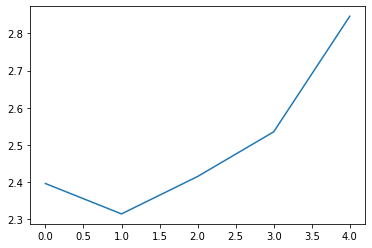

In [3]:
data['eval/loss']['eval/loss'].plot()

<AxesSubplot:>

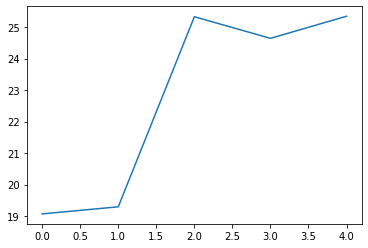

In [4]:
data['eval/rouge1']['eval/rouge1'].plot()

<AxesSubplot:>

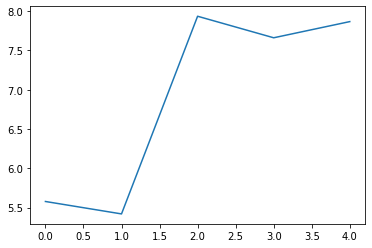

In [5]:
data['eval/rouge2']['eval/rouge2'].plot()